#Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#Import Packages

In [ ]:
import pywt
import math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import skew, kurtosis, variation
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', palette='Dark2')
import warnings
warnings.filterwarnings("ignore")

#Load Dataset

In [ ]:
#Read dataset into pandas dataframe
data = pd.read_csv('/content/gdrive/MyDrive/data.csv')

#Create copy of original data
df = data.copy()

#Meta data
df_meta = pd.DataFrame([[1, 'F', 11],
                        [4, 'M', 22],
                        [7, 'F', 14.5],
                        [10, 'M', 3],
                        [13, 'F', 3],
                        [16, 'F', 7],
                        [19, 'F', 19]],
                       columns=['Id', 'Gender', 'Age'])

#EDA and Preprocessing

##Print values

In [ ]:
#Print first 5 values
data.head()

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,C4-P4,P4-O2,FP2-F8,F8-T8,T8-P8,P8-O2,FZ-CZ,CZ-PZ,seizure
0,-50.598291,118.192918,161.953602,42.783883,133.040293,-213.919414,311.990232,41.221001,56.849817,-2.148962,23.247863,45.909646,76.776557,-15.433455,-31.062271,93.577534,15.824176,28.327228,0.0
1,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.0
2,0.195360,0.195360,0.195360,0.195360,0.195360,0.586081,-0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.586081,0.195360,0.195360,0.195360,0.0
3,0.195360,0.195360,0.195360,0.195360,0.195360,0.976801,-0.976801,0.195360,0.195360,0.195360,0.195360,0.976801,0.195360,0.195360,0.976801,0.195360,0.195360,0.195360,0.0
4,0.195360,0.195360,-0.195360,0.195360,0.586081,-2.539683,2.148962,-0.195360,0.976801,-0.976801,0.195360,-2.148962,0.195360,0.976801,-3.711844,0.195360,-0.586081,-3.321123,0.0


##Gender Count

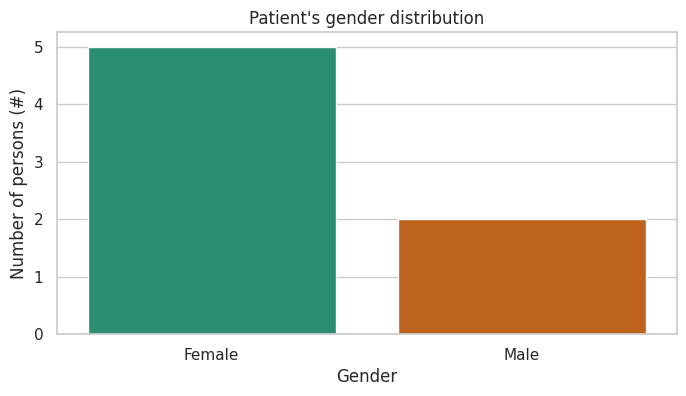

In [ ]:
#Gender Distribution
plt.figure(figsize=(8,4),dpi=100)
sns.countplot(df_meta['Gender']);
plt.ylabel("Number of persons (#)")
plt.xticks(range(0,2), ["Female","Male"])
plt.title("Patient's gender distribution");

##Age Distribution

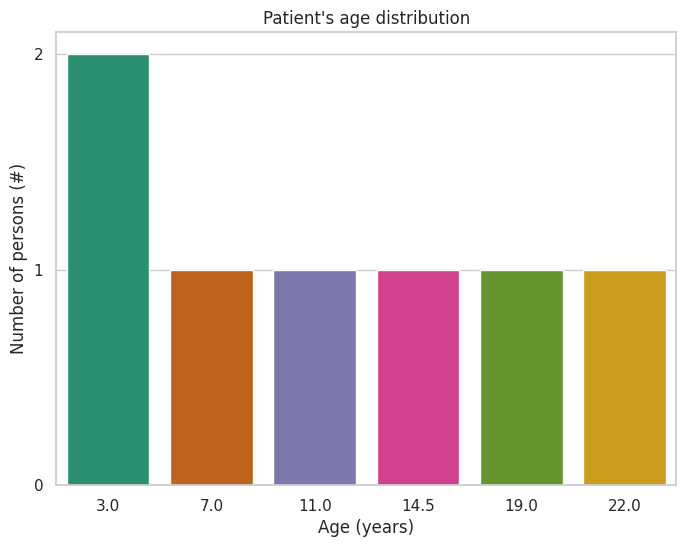

In [ ]:
from matplotlib.ticker import MaxNLocator
ax = plt.figure(figsize=(8,6),dpi=100).gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

#Age Distribution
# plt.figure(figsize=(8,6),dpi=100)
sns.countplot(df_meta['Age']);
plt.xlabel("Age (years)")
plt.ylabel("Number of persons (#)")
plt.title("Patient's age distribution");

##ECG Patterns

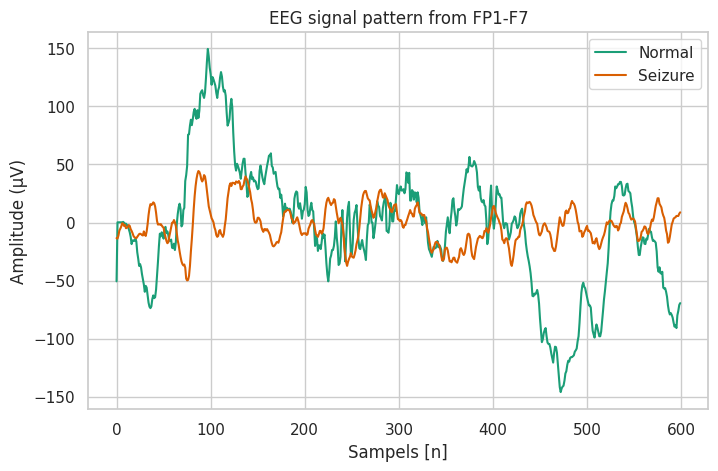

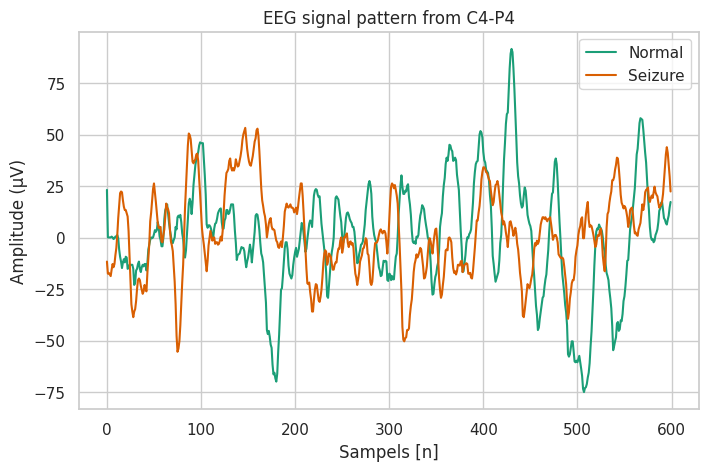

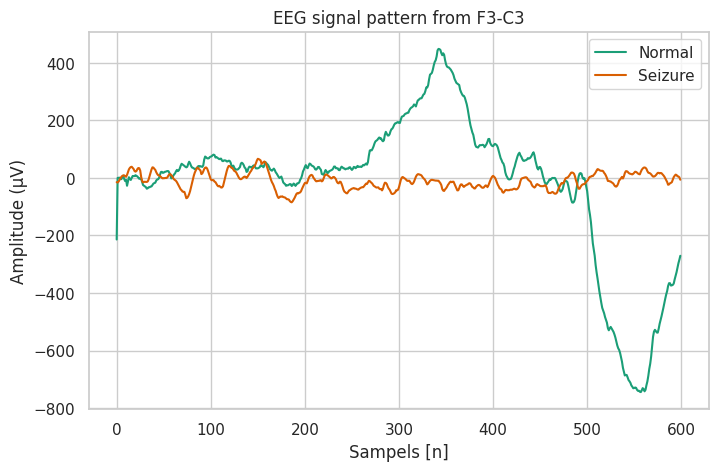

In [ ]:
#Get EEG patterns from seizure and non-seizure activity
df_subsample1 = df[ df['seizure'] == 0.0 ].iloc[:600]
df_subsample2 = df[ df['seizure'] == 1.0 ].iloc[:600]

#Plot the EEG patterns for normal and seizure attack
channel_name = 'FP1-F7'
plt.figure(figsize=(8,5), dpi=100)
plt.plot(range(len(df_subsample1)), df_subsample1[channel_name])
plt.plot(range(len(df_subsample2)), df_subsample2[channel_name])
plt.xlabel("Sampels [n]")
plt.ylabel("Amplitude (µV)")
plt.title("EEG signal pattern from "+channel_name)
plt.legend(['Normal', 'Seizure'])

channel_name = 'C4-P4'
plt.figure(figsize=(8,5), dpi=100)
plt.plot(range(len(df_subsample1)), df_subsample1[channel_name])
plt.plot(range(len(df_subsample2)), df_subsample2[channel_name])
plt.xlabel("Sampels [n]")
plt.ylabel("Amplitude (µV)")
plt.title("EEG signal pattern from "+channel_name)
plt.legend(['Normal', 'Seizure'])

channel_name = 'F3-C3'
plt.figure(figsize=(8,5), dpi=100)
plt.plot(range(len(df_subsample1)), df_subsample1[channel_name])
plt.plot(range(len(df_subsample2)), df_subsample2[channel_name])
plt.xlabel("Sampels [n]")
plt.ylabel("Amplitude (µV)")
plt.title("EEG signal pattern from "+channel_name)
plt.legend(['Normal', 'Seizure'])

##Feature Extraction

In [ ]:
#Compute average power spectral density
def compute_average_power (signal, Fs, window):
  #Frequency bands
  Freq_bands = [0.5, 4, 8, 12, 30, 100]
  #Calculate power spectral density
  freqs, psd = welch(signal, Fs, nperseg = window)
  #List for storing average power
  average_pow=[]
  #Iterate over frequency bands
  while len(Freq_bands)>1:
    #Index ids
    ids = np.logical_and(freqs >= Freq_bands[0], freqs <= Freq_bands[1])
    #Integrate the psd to calculate average power
    integrate_power = simps(psd[ids], dx=Freq_bands[1]-Freq_bands[0])
    #Store the average power
    average_pow.append(integrate_power)
    Freq_bands = np.copy(Freq_bands[1:])
  #Return the stored power values
  for power in average_pow:
      yield power

#Compute Statistical features
def Statistical_features(signal):
  #Signal mean value
  mean = np.mean(signal)
  #Signal variance
  variance = np.var(signal)
  #Skewness in signal distribution
  sk = skew(signal)
  #Signal kurtosis
  kurtos = kurtosis(signal)
  #Standard deviation of the signal
  std = np.std(signal)
  #Median value of the signal
  median = np.median(signal)
  #Zero crossing ratio of the signal
  zero_cross = ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)
  #Signal variation coefficient
  if signal.mean() != 0:
      cv = variation(signal)
  else:
      cv = math.nan
  #Root Mean Squared value
  if signal.size > 0:
      Root_Mean_Square = np.sqrt(signal.dot(signal)/signal.size)
  else:
      Root_Mean_Square = math.nan
  #Peak to Peak distance
  Peak2Peak = signal.max() - signal.min()
  return mean, variance, sk, kurtos, std, median, zero_cross, cv, Root_Mean_Square, Peak2Peak

In [ ]:
#Sampling frequency
Fs = 256

#Window size
window = 512

#Create dataframe to store the extracted features
df_feature = pd.DataFrame()

#Total samples in the data
total_samples = df.shape[0]

#Total number of channels
num_channels = df.shape[1]

#index variable
r = 0

#Iterate over each window
for i in range(0, total_samples, window):
  #Fetch current window
  current_win = df.iloc[i:i+window]

  #Iterate over each channel
  for j in range(0, num_channels-1):
    #Segment from each channel
    segment = np.array(current_win.iloc[:, j])

    # Extract time domain features
    mean, var, sk, kurt, std, med, zcr, cv, rms, P2P = Statistical_features(segment)
    df_feature.loc[r, 'Mean'+str(j)]       = mean
    df_feature.loc[r, 'Variance'+str(j)]   = var
    df_feature.loc[r, 'Skew'+str(j)]       = sk
    df_feature.loc[r, 'kurtosis'+str(j)]   = kurt
    df_feature.loc[r, 'std'+str(j)]        = std
    df_feature.loc[r, 'median'+str(j)]     = med 
    df_feature.loc[r, 'Zero_cross'+str(j)] = zcr
    df_feature.loc[r, 'var_coef'+str(j)]   = cv
    df_feature.loc[r, 'RMS'+str(j)]        = rms
    df_feature.loc[r, 'P2P'+str(j)]        = P2P

    # Extract frequency domain features
    b1, b2, b3, b4, b5 = compute_average_power(segment, Fs, window)
    df_feature.loc[r, 'Band1'+str(j)] = b1
    df_feature.loc[r, 'Band2'+str(j)] = b2
    df_feature.loc[r, 'Band3'+str(j)] = b3
    df_feature.loc[r, 'Band4'+str(j)] = b4
    df_feature.loc[r, 'Band5'+str(j)] = b5

  #Label for current window
  df_feature.loc[r, 'seizure'] = current_win['seizure'].value_counts().idxmax()
  #Increment index
  r+=1

In [ ]:
#Print the features created
list(df_feature.columns)

##Feature Normalization and Cleaning

In [ ]:
#Function for feature normalization
def Normalization(df):
  #Get standard scaler
  Scaler = StandardScaler()
  #Scale the features
  df_scaled = Scaler.fit_transform(df.iloc[:, :df.shape[1]-1])
  #Store the result to dataframe
  feature_norm = pd.DataFrame(df_scaled)
  #Attach the labels
  feature_norm['seizure'] = df['seizure'].copy()
  #Remove non-numeric values from the features
  feature_norm.replace([np.inf, -np.inf], np.nan, inplace = True)
  feature_norm.dropna(inplace = True)
  return feature_norm

#Perform normalization
df_feature = Normalization(df_feature)

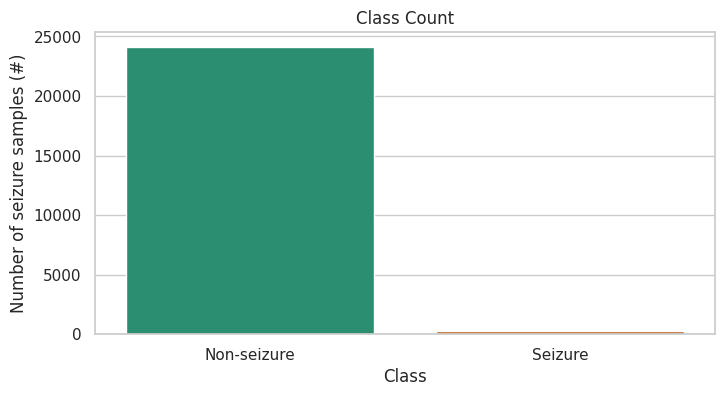

In [ ]:
#Seizure Distribution
plt.figure(figsize=(8,4),dpi=100)
sns.countplot(df_feature['seizure']);
plt.ylabel("Number of seizure samples (#)")
plt.xlabel("Class")
plt.xticks(range(0,2), ["Non-seizure","Seizure"])
plt.title("Class Count");

##Undersampling

In [ ]:
#Function to perform undersampling
def Undersampling(df, lab_col, rate):
  #Using Cluster Centriods method
  sampler = ClusterCentroids(sampling_strategy = rate)
  #Perform resampling
  df_sampled, df_label = sampler.fit_resample(df, lab_col)
  df_sampled['seizure'] = df_label
  return df_sampled

#Resampling ratio
rate = 0.2

#Dataset after resampling majority class
df_feature = Undersampling(df_feature.loc[:, df_feature.columns != 'seizure'],
                           df_feature['seizure'],
                           rate)

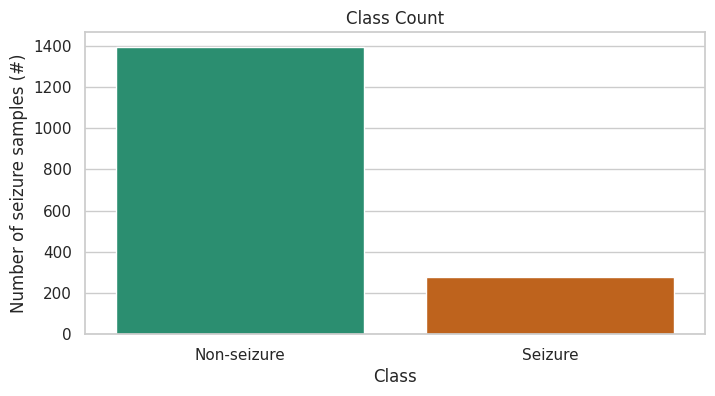

In [ ]:
#Seizure Distribution
plt.figure(figsize=(8,4),dpi=100)
sns.countplot(df_feature['seizure']);
plt.ylabel("Number of seizure samples (#)")
plt.xlabel("Class")
plt.xticks(range(0,2), ["Non-seizure","Seizure"])
plt.title("Class Count");

##Oversampling

In [ ]:
def Oversampling(df, lab_col, neighbors):
  #Using ADASYN technique of oversampling
  sampler = ADASYN(sampling_strategy='minority', n_neighbors = neighbors)
  #Resampling
  df_sampled, df_label = sampler.fit_resample(df, lab_col)
  df_sampled['seizure'] = df_label
  return df_sampled

#ADASYN Neighbors
neigh = 11

#Dataset after oversampling minority class
df_feature = Oversampling(df_feature.loc[:, df_feature.columns != 'seizure'],
                          df_feature['seizure'],
                          neigh)

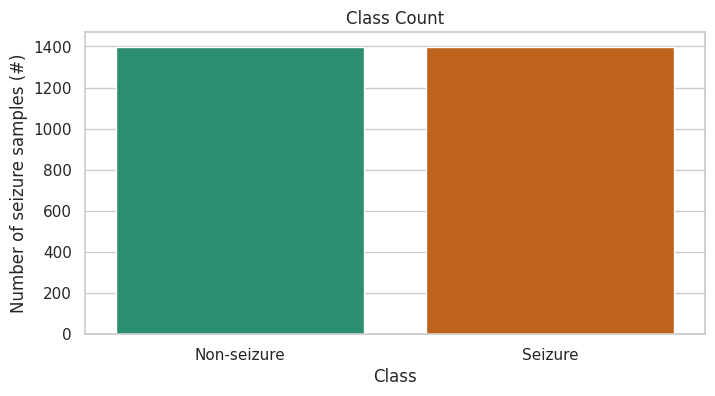

In [ ]:
#Seizure Distribution
plt.figure(figsize=(8,4),dpi=100)
sns.countplot(df_feature['seizure']);
plt.ylabel("Number of seizure samples (#)")
plt.xlabel("Class")
plt.xticks(range(0,2), ["Non-seizure","Seizure"])
plt.title("Class Count");

#Store

In [ ]:
#Store extracted features to CSV file
df_feature.to_csv('df_features.csv')

#Move CSV file to Gdrive for storage
!mv df_features.csv /content/gdrive/MyDrive/